# 05 – Vecinos, UMAP integrado y clustering global para Level1

Notebook dedicado a:
- construir el grafo de vecinos k-NN sobre el embedding Harmony,
- calcular un UMAP integrado,
- obtener un clustering Leiden global que servirá de base para Level1.

Trabaja sobre el objeto con Harmony generado en el notebook 04.

## 1. Contexto: vecinos, UMAP y clustering

- **Vecinos k-NN**: se calculan en el espacio integrado de Harmony (`X_pca_harmony`) y se usan para:
  - clustering Leiden,
  - UMAP.
- **UMAP**: embedding 2D para visualizar la estructura global de los datos integrados.
- **Leiden**: algoritmo de clustering sobre el grafo de vecinos; la resolución controla cuántos clusters se generan.
- El resultado será un clustering global (`leiden_L1`) pensado como base para anotar linajes Level1.

In [1]:
from pathlib import Path
import json

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

print("Scanpy:", sc.__version__)
print("AnnData:", ad.__version__)

Scanpy: 1.11.5
AnnData: 0.12.6


C:\Users\Coni\AppData\Local\Temp\ipykernel_228\1154666483.py:9: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Scanpy:", sc.__version__)
C:\Users\Coni\AppData\Local\Temp\ipykernel_228\1154666483.py:10: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print("AnnData:", ad.__version__)


## 2. Organización de carpetas y configuración básica

- Se asume este notebook en `notebooks/` y se definen:
  - `PROJECT_ROOT`, `AI_PACKAGE_DIR`, `DATA_RAW_DIR`, `DATA_PROCESSED_DIR`.
- Se lee `AI_Package/MANIFEST.json` (si existe) para recuperar claves estándar:
  - `EMB_KEY` (p.ej. `"X_pca_harmony"`),
  - `NBR_KEY` (p.ej. `"harmony"`),
  - `UMAP_KEY` (p.ej. `"X_umap_harmony"`).
- Archivo de entrada configurado en:
  - `HARMONY_H5AD_PATH = data_processed/TFM_CIRRHOSIS_harmony.h5ad`.

In [2]:
# Detectamos la carpeta raíz del proyecto asumiendo que este notebook está en "notebooks/"
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

AI_PACKAGE_DIR      = PROJECT_ROOT / "AI_Package"
DATA_RAW_DIR        = PROJECT_ROOT / "data_raw"
DATA_PROCESSED_DIR  = PROJECT_ROOT / "data_processed"
DATA_PROCESSED_DIR.mkdir(exist_ok=True)

print("Directorio del notebook:", NOTEBOOK_DIR)
print("Raíz del proyecto:", PROJECT_ROOT)
print("Carpeta AI_Package:", AI_PACKAGE_DIR)
print("Carpeta data_raw:", DATA_RAW_DIR)
print("Carpeta data_processed:", DATA_PROCESSED_DIR)

# Leemos MANIFEST.json para recuperar las claves estándar
manifest_path = AI_PACKAGE_DIR / "MANIFEST.json"
if manifest_path.exists():
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
else:
    manifest = {}
    print("\n[AVISO] No se ha encontrado MANIFEST.json; se usarán valores por defecto.")

EMB_KEY = manifest.get("keys", {}).get("EMB_KEY", "X_pca_harmony")
NBR_KEY = manifest.get("keys", {}).get("NBR_KEY", "harmony")
UMAP_KEY = manifest.get("keys", {}).get("UMAP_KEY", "X_umap_harmony")

CONFIG = {
    "PROJECT_ROOT": PROJECT_ROOT,
    "AI_PACKAGE_DIR": AI_PACKAGE_DIR,
    "DATA_RAW_DIR": DATA_RAW_DIR,
    "DATA_PROCESSED_DIR": DATA_PROCESSED_DIR,
    # Usamos el objeto con Harmony completo (no subset HVG)
    "HARMONY_H5AD_PATH": DATA_PROCESSED_DIR / "TFM_CIRRHOSIS_harmony.h5ad",
    "EMB_KEY": EMB_KEY,
    "NBR_KEY": NBR_KEY,
    "UMAP_KEY": UMAP_KEY,
}

CONFIG

Directorio del notebook: D:\Users\Coni\Documents\TFM_CirrhosIS\notebooks
Raíz del proyecto: D:\Users\Coni\Documents\TFM_CirrhosIS
Carpeta AI_Package: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package
Carpeta data_raw: D:\Users\Coni\Documents\TFM_CirrhosIS\data_raw
Carpeta data_processed: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed


{'PROJECT_ROOT': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS'),
 'AI_PACKAGE_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package'),
 'DATA_RAW_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_raw'),
 'DATA_PROCESSED_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed'),
 'HARMONY_H5AD_PATH': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed/TFM_CIRRHOSIS_harmony.h5ad'),
 'EMB_KEY': 'X_pca_harmony',
 'NBR_KEY': 'harmony',
 'UMAP_KEY': 'X_umap_harmony'}

## 3. Carga del objeto con Harmony

- Se carga `TFM_CIRRHOSIS_harmony.h5ad` desde `data_processed/`.
- Este objeto contiene:
  - todas las células tras QC,
  - expresión normalizada/log1p,
  - genes HVG anotados (`var["highly_variable"]`),
  - embedding integrado de Harmony en `adata.obsm[EMB_KEY]`.
- Se comprueba que `adata.obsm[EMB_KEY]` (normalmente `"X_pca_harmony"`) existe
  y se informa de su forma (n_células × n_PCs).

In [3]:
# 3. Carga del objeto con Harmony

harmony_h5ad_path = CONFIG["HARMONY_H5AD_PATH"]

if not harmony_h5ad_path.exists():
    raise FileNotFoundError(
        f"No se encuentra el archivo con Harmony en:\n{harmony_h5ad_path}\n"
        "Asegúrate de que has ejecutado el notebook de Harmony (04) o ajusta CONFIG['HARMONY_H5AD_PATH']."
    )

adata = sc.read_h5ad(harmony_h5ad_path)
print(adata)

# Comprobamos que el embedding Harmony está presente
if CONFIG["EMB_KEY"] not in adata.obsm.keys():
    raise KeyError(
        f"No se encontró la clave '{CONFIG['EMB_KEY']}' en adata.obsm.\n"
        "Revisa el notebook de Harmony o ajusta EMB_KEY en el MANIFEST o en este notebook."
    )

emb = adata.obsm[CONFIG["EMB_KEY"]]
print(f"\nEmbedding Harmony encontrado en adata.obsm['{CONFIG['EMB_KEY']}'] con forma:", emb.shape)


AnnData object with n_obs × n_vars = 225944 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'disease_colors', 'gem_id_colors', 'hvg', 'log1p'
    obsm: 'X_pca', 'X_p

## 4. Construcción del grafo de vecinos (k-NN)

- Se usa `scanpy.pp.neighbors` con:
  - `n_neighbors = 15` (ajustable),
  - `use_rep = EMB_KEY` → embedding Harmony,
  - `key_added = NBR_KEY` → por defecto `"harmony"`.
- Se guarda:
  - configuración del grafo en `adata.uns[NBR_KEY]`,
  - matrices de conectividades/distancias en `adata.obsp["connectivities"]`
    y `adata.obsp["distances"]`.

In [4]:
# 4. Construcción del grafo de vecinos (k-NN)

# Parámetros de vecinos (ajustables)
N_NEIGHBORS = 15  # número de vecinos k-NN

print(f"Calculando grafo de vecinos con n_neighbors = {N_NEIGHBORS}, use_rep = '{CONFIG['EMB_KEY']}' ...")

sc.pp.neighbors(
    adata,
    n_neighbors=N_NEIGHBORS,
    use_rep=CONFIG["EMB_KEY"],
    key_added=CONFIG["NBR_KEY"],
)

print(f"Grafo de vecinos almacenado en adata.uns['{CONFIG['NBR_KEY']}'].")
print("Matrices de conectividad/distancia guardadas en adata.obsp['connectivities'] y adata.obsp['distances'].")

Calculando grafo de vecinos con n_neighbors = 15, use_rep = 'X_pca_harmony' ...


C:\Users\Coni\miniconda3\envs\tfm-cirrhosis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Grafo de vecinos almacenado en adata.uns['harmony'].
Matrices de conectividad/distancia guardadas en adata.obsp['connectivities'] y adata.obsp['distances'].


## 5. Cálculo del embedding UMAP integrado

- A partir del grafo de vecinos (`neighbors_key = NBR_KEY`) se calcula UMAP:
  - `min_dist = 0.3`,
  - `spread = 1.0`,
  - `random_state = 0`.
- Se llama a `scanpy.tl.umap` con:
  - `neighbors_key = NBR_KEY`,
  - `key_added = UMAP_KEY` → normalmente `"X_umap_harmony"`.
- El embedding UMAP se guarda en `adata.obsm[UMAP_KEY]`
  (matriz n_células × 2).

In [5]:
# 5. Cálculo del embedding UMAP integrado

# Parámetros UMAP (ajustables)
MIN_DIST = 0.3
SPREAD = 1.0
RANDOM_STATE = 0

print(
    f"Calculando UMAP integrado con neighbors_key = '{CONFIG['NBR_KEY']}', "
    f"key_added = '{CONFIG['UMAP_KEY']}' ..."
)

sc.tl.umap(
    adata,
    neighbors_key=CONFIG["NBR_KEY"],
    min_dist=MIN_DIST,
    spread=SPREAD,
    random_state=RANDOM_STATE,
    key_added=CONFIG["UMAP_KEY"],
)

print(f"UMAP integrado guardado en adata.obsm['{CONFIG['UMAP_KEY']}'].")
print("Forma del embedding UMAP:", adata.obsm[CONFIG["UMAP_KEY"]].shape)

Calculando UMAP integrado con neighbors_key = 'harmony', key_added = 'X_umap_harmony' ...
UMAP integrado guardado en adata.obsm['X_umap_harmony'].
Forma del embedding UMAP: (225944, 2)


(Si la versión de Scanpy no acepta key_added en sc.tl.umap, habría que adaptar: usar el UMAP por defecto en "X_umap" y luego copiarlo a "X_umap_harmony".)

## 6. Visualización exploratoria del UMAP

- Se identifica una posible columna de batch para colorear:
  - prioridad: `gem_id` → `libraryID` → `sample` → `sample_id` → `batch` → `patientID`.
- Se elabora una lista de variables para colorear el UMAP:
  - batch_key (si existe),
  - `disease`, `patientID`,
  - métricas de QC (`total_counts`, `n_genes_by_counts`, `pct_counts_mt`) si están disponibles.
- Se usa `scanpy.pl.embedding` con:
  - `basis = UMAP_KEY`,
  - `color = color_vars`,
  - para revisar integración, efecto de batch y gradientes de calidad.

Batch key para visualización (si existe): gem_id
Variables que usaremos para colorear UMAP: ['gem_id', 'disease', 'patientID', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt']


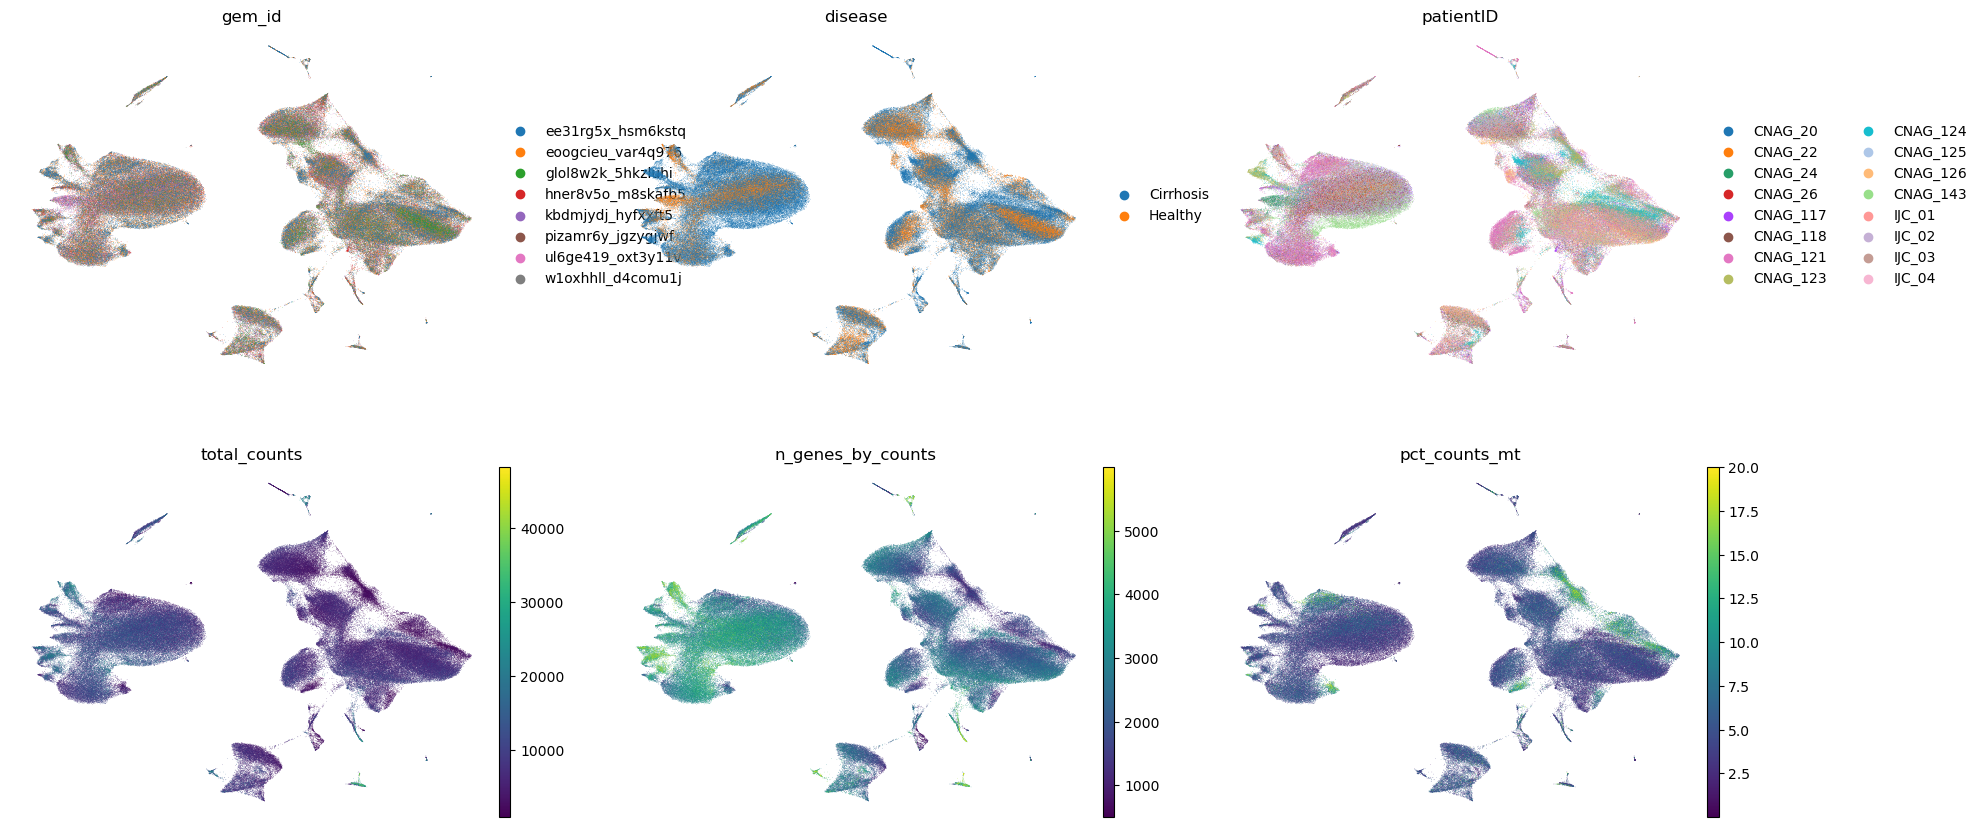

In [6]:
# 6. Visualización exploratoria del UMAP

# Detectamos una batch_key para colorear (incluimos gem_id)
available_obs = list(adata.obs.columns)

batch_key = None
if "gem_id" in adata.obs.columns and adata.obs["gem_id"].nunique() > 1:
    batch_key = "gem_id"
elif "libraryID" in adata.obs.columns and adata.obs["libraryID"].nunique() > 1:
    batch_key = "libraryID"
elif "sample" in adata.obs.columns and adata.obs["sample"].nunique() > 1:
    batch_key = "sample"
elif "sample_id" in adata.obs.columns and adata.obs["sample_id"].nunique() > 1:
    batch_key = "sample_id"
elif "batch" in adata.obs.columns and adata.obs["batch"].nunique() > 1:
    batch_key = "batch"
elif "patientID" in adata.obs.columns and adata.obs["patientID"].nunique() > 1:
    batch_key = "patientID"

print("Batch key para visualización (si existe):", batch_key)

# Preparamos lista de variables para colorear
color_vars = []

# Primero, el batch (si existe)
if batch_key is not None:
    color_vars.append(batch_key)

# Después, variables biológicas y de QC
for col in ["disease", "patientID", "total_counts", "n_genes_by_counts", "pct_counts_mt"]:
    if col in adata.obs.columns:
        color_vars.append(col)

print("Variables que usaremos para colorear UMAP:", color_vars)

# Visualización de UMAP integrado (embedding en CONFIG["UMAP_KEY"])
if color_vars:
    sc.pl.embedding(
        adata,
        basis=CONFIG["UMAP_KEY"],
        color=color_vars,
        ncols=3,
        frameon=False
    )
else:
    print("No se han encontrado columnas adecuadas para colorear UMAP.")

## 7. Clustering global (Leiden) para Level1

- Sobre el grafo de vecinos (`neighbors_key = NBR_KEY`) se calculan varios clusterings Leiden:
  - resoluciones `0.2`, `0.5`, `0.8`.
  - cada uno se guarda en `adata.obs["leiden_r0_2"]`, `["leiden_r0_5"]`, `["leiden_r0_8"]`.
- Se elige como clustering “base” para Level1:
  - `LEIDEN_L1_KEY = "leiden_r0_5"`.
- Se crea la columna:
  - `adata.obs["leiden_L1"] = adata.obs["leiden_r0_5"].astype("category")`.
- Se visualiza el UMAP integrado coloreado por `leiden_L1` para evaluar la granularidad global.

Calculando clustering Leiden con resolución 0.2 -> obs['leiden_r0_2'] ...


C:\Users\Coni\AppData\Local\Temp\ipykernel_228\3303010919.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Calculando clustering Leiden con resolución 0.5 -> obs['leiden_r0_5'] ...
Calculando clustering Leiden con resolución 0.8 -> obs['leiden_r0_8'] ...

Clusterings Leiden calculados: ['leiden_r0_2', 'leiden_r0_5', 'leiden_r0_8']
Columna principal de clustering para Level1 definida en obs['leiden_L1'].


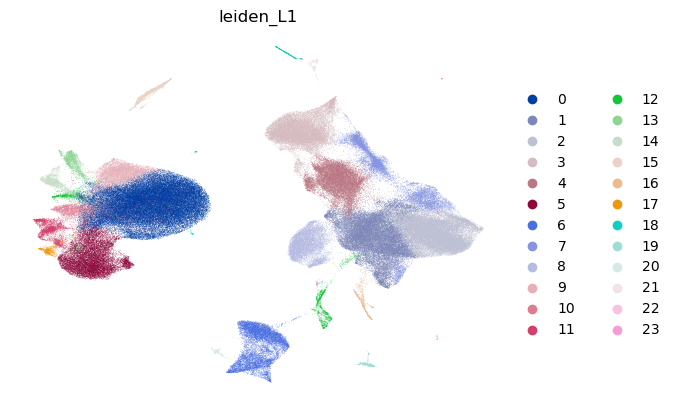

In [7]:
# 7. Clustering global (Leiden) para Level1

# Resoluciones de Leiden a explorar
LEIDEN_RESOLUTIONS = [0.2, 0.5, 0.8]

leiden_keys = []

for res in LEIDEN_RESOLUTIONS:
    key = f"leiden_r{str(res).replace('.', '_')}"
    print(f"Calculando clustering Leiden con resolución {res} -> obs['{key}'] ...")
    sc.tl.leiden(
        adata,
        resolution=res,
        key_added=key,
        neighbors_key=CONFIG["NBR_KEY"],
    )
    leiden_keys.append(key)

print("\nClusterings Leiden calculados:", leiden_keys)

# Elegimos una resolución "intermedia" como base para Level1 (ajustable)
LEIDEN_L1_KEY = "leiden_r0_5"
if LEIDEN_L1_KEY not in adata.obs.columns:
    raise KeyError(
        f"No se encontró la columna '{LEIDEN_L1_KEY}' en adata.obs.\n"
        "Revisa la lista de resoluciones calculadas o ajusta LEIDEN_L1_KEY."
    )

adata.obs["leiden_L1"] = adata.obs[LEIDEN_L1_KEY].astype("category")
print("Columna principal de clustering para Level1 definida en obs['leiden_L1'].")

# Visualizamos el UMAP coloreado por el clustering global elegido
sc.pl.embedding(
    adata,
    basis=CONFIG["UMAP_KEY"],
    color=["leiden_L1"],
    frameon=False,
)

## 8. Guardado del objeto con vecinos, UMAP y clustering global

- Se guarda el AnnData enriquecido con:
  - embedding Harmony (`obsm[EMB_KEY]`),
  - grafo de vecinos (`uns[NBR_KEY]`, `obsp["connectivities"]`, `obsp["distances"]`),
  - UMAP integrado (`obsm[UMAP_KEY]`),
  - clusterings Leiden a varias resoluciones,
  - `obs["leiden_L1"]` como clustering principal.
- Ruta de salida:
  - `data_processed/TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad`.

In [8]:
# 8. Guardado del objeto con vecinos, UMAP y clustering global

# Guardamos el objeto completo con Harmony + vecinos + UMAP + Leiden
neighbors_umap_h5ad_path = CONFIG["DATA_PROCESSED_DIR"] / "TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad"
adata.write_h5ad(neighbors_umap_h5ad_path)

print("Objeto con vecinos, UMAP y clustering global guardado en:")
print(neighbors_umap_h5ad_path)

Objeto con vecinos, UMAP y clustering global guardado en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad


## 9. Resumen de este notebook

- Entrada:
  - `TFM_CIRRHOSIS_harmony.h5ad` con embedding integrado Harmony sobre HVG.
- Operaciones realizadas:
  - construcción del grafo k-NN en el espacio `X_pca_harmony`,
  - cálculo de UMAP integrado (2D) usando ese grafo,
  - clustering Leiden en varias resoluciones y definición de `leiden_L1`.
- Salida:
  - `TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad`,
  - listo para:
    - anotación de linajes Level1,
    - división por linajes y análisis Level2 en notebooks posteriores.

## Comentarios

- En la ejecución del TFM:
  - el UMAP coloreado por `gem_id` muestra buena mezcla de bibliotecas,
  - `disease` y `patientID` se distribuyen coherentemente entre linajes,
  - las métricas de QC no forman “islas” de baja calidad.
- La resolución `0.5` se adopta como `leiden_L1` porque:
  - separa bien los linajes inmunes principales,
  - sin fragmentar excesivamente poblaciones biológicamente homogéneas.